# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: Classify Gaussian blurs
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [196]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/var/folders/4x/pds2gxg17h57rrp30d736s1w0000gn/T/ipykernel_45060/2973059004.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Create Gaussian blurs with different widths

In [197]:
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x) #((91, 91), (91, 91))

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )
  
  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5
  
  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

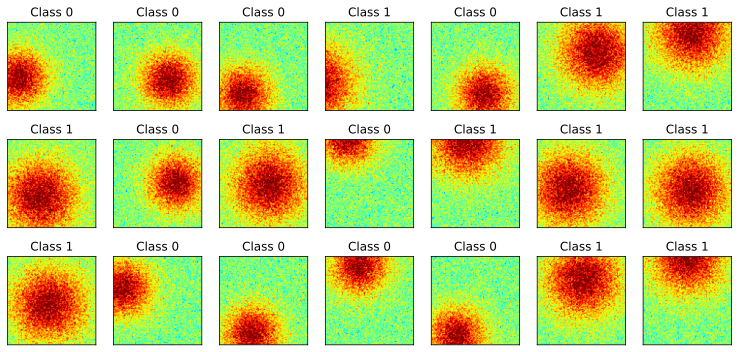

In [198]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(2*nPerClass)
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create train/test groups using DataLoader

In [199]:
# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [200]:
# check size (should be images X channels X width X height
print( train_loader.dataset.tensors[0].shape )
print( train_loader.dataset.tensors[1].shape )

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


# Create the DL model

In [201]:
# create a class for the model
def makeTheNet():

  class gausnet(nn.Module):
    def __init__(self):
      super().__init__()
      
      # all layers in one go using nn.Sequential
      self.enc = nn.Sequential(
          nn.Conv2d(1,4,3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
          nn.ReLU(),                   # note that relu is treated like a "layer"
          nn.AvgPool2d(2,2),           # output size: 91/2 = 45 
          nn.Conv2d(4,6,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
          nn.ReLU(),                   # 
          nn.AvgPool2d(2,2),           # output size: 45/2 = 22
          nn.Flatten(),                # vectorize conv output
          nn.Linear(22*22*6,50),       # output size: 50
          nn.Linear(50,1),             # output size: 1
      )
      
    def forward(self,x):
      return self.enc(x)
  
  # create the model instance
  net = gausnet()
  
  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [202]:
# # create a class for the model
# def makeTheNet():

#   class gausnet(nn.Module):
#     def __init__(self):
#       super().__init__()
      
#       # conv1
#       self.conv1 = nn.Conv2d(1,6,3,padding=1)
#       # output size: (91+2*1-3)/1 + 1 = 91
#       # post-pooling: 91/2 = 45

#       # conv2
#       self.conv2 = nn.Conv2d(6,4,3,padding=1)
#       # output size: (45+2*1-3)/1 + 1 = 45
#       # post-pooling: 45/2 = 22

#       # fc1
#       self.fc1 = nn.Linear(22*22*4,50)

#       # fc2 (output)
#       self.fc2 = nn.Linear(50,1)
      
#     def forward(self,x):
#       # first conv-pool set
#       conv1act = F.relu(self.conv1(x))
#       x = F.avg_pool2d(conv1act,(2,2))
      
#       # second conv-pool set
#       conv2act = F.relu(self.conv2(x))
#       x = F.avg_pool2d(conv2act,(2,2))

#       # ANN part
#       x = x.reshape(x.shape[0],-1)
#       x = self.fc1(x) 
#       x = self.fc2(x)
      
#       return x

#   # create the model instance
#   net = gausnet()
  
#   # loss function
#   lossfun = nn.BCEWithLogitsLoss()

#   # optimizer
#   optimizer = torch.optim.Adam(net.parameters(),lr=.001)

#   return net,lossfun,optimizer

In [203]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

# check size of output
print(' ')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)

 
torch.Size([32, 1])
 
Loss:
tensor(0.6936, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [204]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 91, 91]              40
              ReLU-2            [-1, 4, 91, 91]               0
         AvgPool2d-3            [-1, 4, 45, 45]               0
            Conv2d-4            [-1, 6, 45, 45]             222
              ReLU-5            [-1, 6, 45, 45]               0
         AvgPool2d-6            [-1, 6, 22, 22]               0
           Flatten-7                 [-1, 2904]               0
            Linear-8                   [-1, 50]         145,250
            Linear-9                    [-1, 1]              51
Total params: 145,563
Trainable params: 145,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.80
Params size (MB): 0.56
Estimated Total Size (MB): 1.38
-------------------------------------------

# Create a function that trains the model

In [205]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  testAcc   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean(( (yHat>0) ==y).float()).item() )
    # end of batch loop...

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # compare the following really long line of code to the training accuracy lines
    testLoss[epochi] = loss.item()
    testAcc[epochi]  = 100*torch.mean(( (yHat>0) ==y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

# Run the model and show the results!

In [206]:
trainLoss,testLoss,trainAcc,testAcc,net = function2trainTheModel()

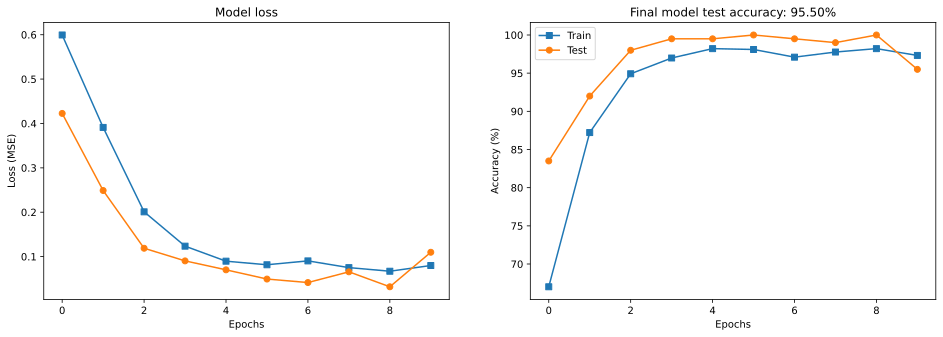

In [207]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

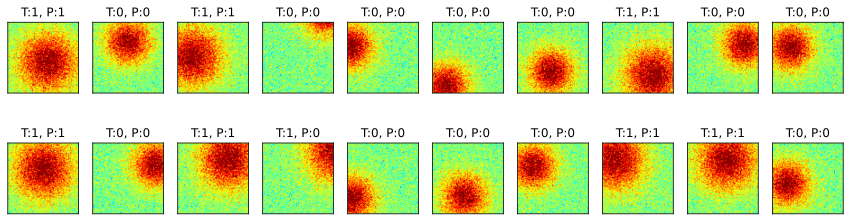

In [208]:
# visualize some images

X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
  G = torch.squeeze( X[i,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[i].item()) , int(yHat[i].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

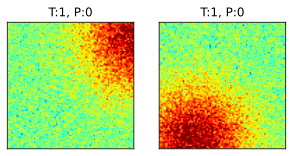

In [209]:
mismatches = np.where((yHat>0)!=y)[0]
fig,axs = plt.subplots(1,2,figsize=(5,5))

for i,ax in enumerate(axs.flatten()):
  idx = mismatches[i]  
  G = torch.squeeze( X[idx,0,:,:] ).detach()
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  t = ( int(y[idx].item()) , int(yHat[idx].item()>0) )
  ax.set_title('T:%s, P:%s'%t)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

In [210]:
print(net)

layer1W = net.enc[0].weight
layer3W = net.enc[3].weight

print(' ')
print(layer1W.shape)
print(layer3W.shape)

gausnet(
  (enc): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(4, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2904, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([4, 1, 3, 3])
torch.Size([6, 4, 3, 3])


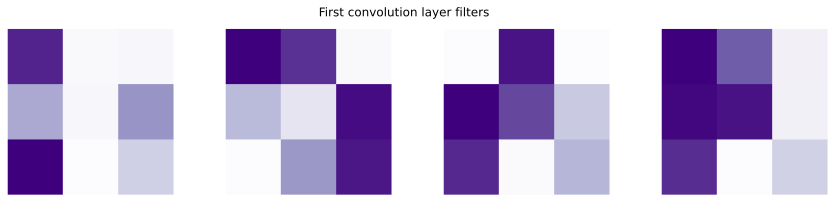

In [211]:
fig,axs = plt.subplots(1,4,figsize=(15,3))

for i,ax in enumerate(axs.flatten()):
  ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach() ,cmap='Purples')
  ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

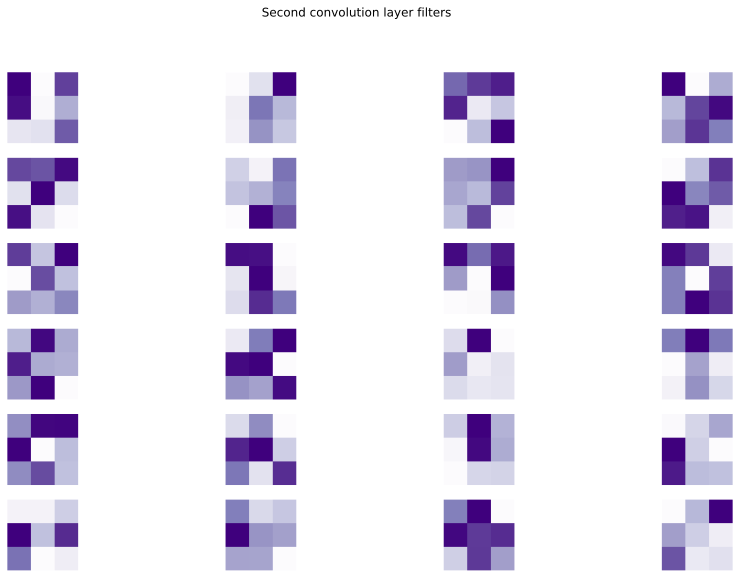

In [212]:
fig,axs = plt.subplots(6,4,figsize=(15,9))

for i in range(6*4):
  idx = np.unravel_index(i,(6,4))
  axs[idx].imshow( torch.squeeze(layer3W[idx[0],idx[1],:,:]).detach() ,cmap='Purples')
  axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()

# Additional explorations

In [213]:
# 1) Rewrite the model architecture without using nn.Sequential. Your final result must be the same as the current version,
#    just defined in a different way. This is great practice at constructing models using classes. 
# MY COMMENT: coded inline
# 2) Find and plot the stimuli that the model guessed incorrectly. Is the correct answer obvious to you? Do the errors
#    tend to be obscured by the boundaries of the image, or is there any other reason you can find for why the model got
#    those wrong?
# MY COMMENT: coded inline. errors tend to be obscured by the boundaries of the image
# 3) Notice the choice of architecture here: 6 channels in the first convolution layer and 4 channels in the second. In
#    the lecture I said that CNNs typically get wider with each successive "convpool block." Does that mean that this
#    model is wrong? Or suboptimal? Think of some arguments for and against this organization. Then modify the code to
#    swap the widths (4 channels in the first conv layer and 6 channels in the second conv layer). Does that affect the
#    model's performance?
# 